# 882 Replication Paper: Flabbi 2010

- Data from CPS, 1995
- Estimation strategy from Flabbi 2010 

## Import Packages

In [108]:
# Data Manipulation 
import numpy as np
import pandas as pd

# General
import pdb

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats
# import numdifftools as ndt
import scipy.integrate as integrate

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns
from pylab import *

## Import Data 

- CPS data on gender, wages, duration of unemployment
- M: males
- F: females
- U: unemployed
- E: employed 
- {M,F} X {E,U} = {males,females} X {employed, unemployed}

In [41]:
data=pd.read_csv('../data/est_c.csv')
data.columns = ['dur', 'wage', 'empl', 'women']

M = data[data['women']==0] #1186 men 
F = data[data['women']==1] #993 women 
U = data[data['empl']==0] #45 unemployed
E = data[data['empl']==1] #2134 employed

ME = M[M['empl']==1] #1168 employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #966 employed women
FU = F[F['empl']==0] #27 unemployed women

### Summary Statistics, without trimming

In [42]:
agg_dict = {
    'wage': ['mean', 'std', 'count'],
    'dur': ['mean', 'std', 'count'],
}

In [43]:
print(data.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrrrr}
\toprule
  &   & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
  &   &       mean &       std & count &      mean &       std & count \\
women & empl &            &           &       &           &           &       \\
\midrule
0 & 0 &   0.000000 &  0.000000 &    18 &  4.923077 &  4.687447 &    18 \\
  & 1 &  21.258393 &  9.890162 &  1168 &  0.000000 &  0.000000 &  1168 \\
1 & 0 &   0.000000 &  0.000000 &    27 &  3.837607 &  3.341191 &    27 \\
  & 1 &  16.604563 &  8.307586 &   966 &  0.000000 &  0.000000 &   966 \\
\bottomrule
\end{tabular}



In [44]:
print(data.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
{} &       mean &       std & count &      mean &       std & count \\
empl &            &           &       &           &           &       \\
\midrule
0    &   0.000000 &  0.000000 &    45 &  4.271795 &  3.921109 &    45 \\
1    &  19.151739 &  9.492563 &  2134 &  0.000000 &  0.000000 &  2134 \\
\bottomrule
\end{tabular}



### Summary Statistics, with trimming

In [45]:
print(np.percentile(ME['wage'], 5))

7.2700000000000005


In [46]:
print(np.percentile(FE['wage'], 5))

5.75625


In [47]:
M_WAGE_COND = (data['wage'] > 7.27) #hard coded percentile so it does not continually update
M_COND = (data['women'] == 0)

F_WAGE_COND = (data['wage'] > 5.75625) #hard coded percentile so it does not continually update
F_COND = (data['women'] == 1)

DUR_COND = (data['dur'] > 0)

trim = data[ (M_COND & M_WAGE_COND) | (F_COND & F_WAGE_COND) | DUR_COND ]


M = trim[trim['women']==0] #1127 men 
F = trim[trim['women']==1] #944 women 
U = trim[trim['empl']==0] #45 unemployed
E = trim[trim['empl']==1] #2026 employed

ME = M[M['empl']==1] #1109 employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #917 employed women
FU = F[F['empl']==0] #27 unemployed women

In [48]:
print(trim.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrrrr}
\toprule
  &   & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
  &   &       mean &       std & count &      mean &       std & count \\
women & empl &            &           &       &           &           &       \\
\midrule
0 & 0 &   0.000000 &  0.000000 &    18 &  4.923077 &  4.687447 &    18 \\
  & 1 &  22.093013 &  9.440473 &  1109 &  0.000000 &  0.000000 &  1109 \\
1 & 0 &   0.000000 &  0.000000 &    27 &  3.837607 &  3.341191 &    27 \\
  & 1 &  17.263817 &  8.002224 &   917 &  0.000000 &  0.000000 &   917 \\
\bottomrule
\end{tabular}



In [49]:
print(trim.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
{} &       mean &       std & count &      mean &       std & count \\
empl &            &           &       &           &           &       \\
\midrule
0    &   0.000000 &  0.000000 &    45 &  4.271795 &  3.921109 &    45 \\
1    &  19.907242 &  9.138453 &  2026 &  0.000000 &  0.000000 &  2026 \\
\bottomrule
\end{tabular}



## Figures 

- Distribution of wages, men and women

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


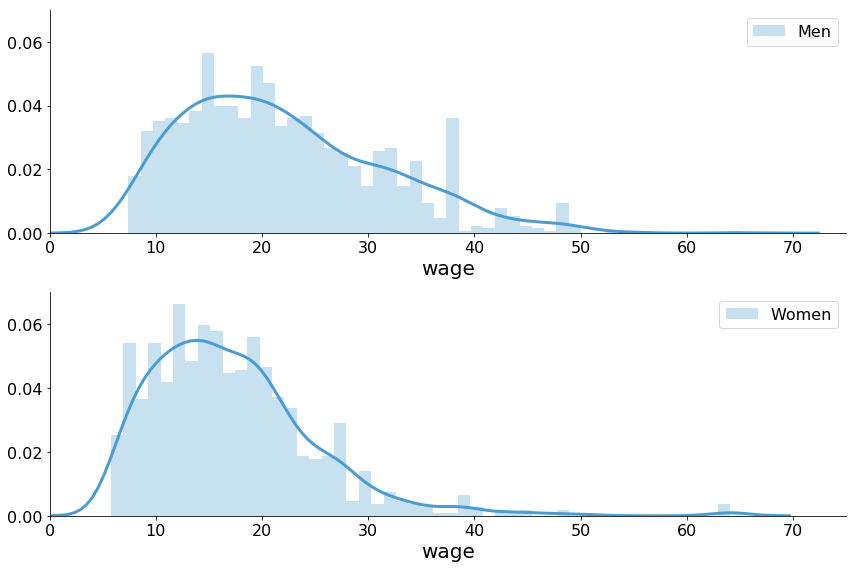

In [50]:
# Seaborn
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(ME['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[0])
sns.distplot(FE['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[1])

ax[0].legend(['Men'])
ax[1].legend(['Women'])

ax[0].set_xlim([0,75])
ax[1].set_xlim([0,75])

ax[0].set_ylim([0,0.07])
ax[1].set_ylim([0,0.07])

plt.tight_layout()

In [51]:
fig.savefig('./figures/fig1_2.png', bbox_inches='tight', transparent=True)

## Estimation 

### Initial Conditions

In [52]:
λ_0 = 0.22
λ_M = 0.18
λ_F = 0.28

h_0 = 0.234
h_M = 0.203
h_F = 0.260

η_0 = 0.005
η_M = 0.003
η_F = 0.0077

μ_0 = 3.433
μ_M = 3.456
μ_F = 3.454

σ_0 = 0.523
σ_M = 0.558
σ_F = 0.423

p_0 = 0.5
d_0 = 15 

### Parameters without distributional assumptions

In [53]:
wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

α = 0.5

### Accepted Wage Distribution as in 13, Log Normal as transformation from Normal

In [54]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [55]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculated lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [56]:
def dens_accepted(wage: np.array, α: float, μ: float, σ: float, wstar: float):
    """
    Calculates the density of accepted wages using the lognormal distribution (end of eq 13)
    """
    
    pdf_in = (wage - (1-α)*wstar)/α
    sf_in = wstar
    
    num = lognormpdf(pdf_in, μ, σ) 
    denom = lognormsf(sf_in, μ, σ)
    
    return num / (α * denom)

In [57]:
def dens_accepted_prej(wage: np.array, α: float, μ: float, σ: float, wstar: float, d: float):
    """
    Calculates the density of accepted wages when prejudice is present using the lognormal distribution (end of eq 13)
    """
    
    pdf_in = (wage + α*d - (1-α)*wstar)/α
    sf_in = wstar+d
    
    num = lognormpdf(pdf_in, μ, σ) 
    denom = lognormsf(sf_in, μ, σ)    
    
    return num / (α * denom)

In [58]:
def hazardM(λ: float, wstar: float, α: float, μ: float, σ: float):
    """
    Estimates hazard rate for men (eq 10 of the paper)
    """

    mult = lognormsf(wstar, μ, σ)
    
    return λ * mult

In [59]:
def hazardF(λ: float, wstar: float, α: float, μ: float, σ: float, p: float, d: float):
    """
    Estimates hazard rate for women (eq 10 of the paper)
    """
    
    sf_in1 = wstar
    sf_in2 = wstar+d
    
    mult = (1-p)*lognormsf(sf_in1, μ, σ) + p*lognormsf(sf_in2, μ, σ)
    
    return λ * mult

### Test Statistics

In [60]:
def teststats (hess_inv: np.ndarray, lnL: float, nparams: int):
    """
    Calculates the standard errors and p value from the LR tests, puts into list to export to .csv file
    """
    se = np.sqrt(np.diag(hess_inv))
    
    loglik_H0 = lnL_6
    
    LR = 2 * (lnL - loglik_H0)
    pval = stats.chi2.pdf(LR, nparams)
    
    ts = se.tolist()
    ts.append(lnL)
    ts.append(pval)
    
    return ts

### Likelihood Functions

#### Estimation 6

In [65]:
def loglik_6( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences (Estimation 6)
    
    Parameters to estimate: λM, λF, ηM, ηF, μM, σM, μF, σF, d, p
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[7])
    d  = np.exp(params[8])
    p  = np.exp(params[9])

    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )  

    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej( FE['wage'], α, μF, σF, wstarF, d)
      
    i = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + h + i)

In [66]:
# Check on log-likelihood

param6 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F, d_0, p_0]

b6_0 = np.log(param6[0])
b6_1 = np.log(param6[1])
b6_2 = np.log(param6[2])
b6_3 = np.log(param6[3])
b6_4 = param6[4]
b6_5 = np.log(param6[5])
b6_6 = param6[6]
b6_7 = np.log(param6[7])
b6_8 = np.log(param6[8])
b6_9 = np.log(1)

init6 = [b6_0, b6_1, b6_2, b6_3, b6_4, b6_5, b6_6, b6_7, b6_8, b6_9]

print(loglik_6(init6))

6042.221472828369


In [67]:
print(init6)

[-1.7147984280919266, -1.2729656758128873, -5.809142990314028, -4.866534950122499, 3.456, -0.583396316600826, 3.454, -0.8603830999358592, 2.70805020110221, 0.0]


In [68]:
est_6 = minimize(loglik_6, init6)

est_6

      fun: 5952.05297318644
 hess_inv: array([[ 3.74988856e-02, -3.68915380e-03,  3.20944010e-02,
        -2.49066431e-03,  1.62064516e-05,  4.66085459e-05,
         3.00984455e-03, -1.17149732e-03, -1.25377794e-02,
         1.98520340e-02],
       [-3.68915380e-03,  2.43647111e-02, -1.29755066e-02,
         1.87298271e-02, -5.53991418e-05, -9.85633808e-05,
        -4.40302759e-03,  3.12563905e-03,  6.81011825e-03,
        -2.21425173e-02],
       [ 3.20944010e-02, -1.29755066e-02,  7.97512119e-02,
        -1.28276268e-02, -3.64119270e-05, -2.27971003e-05,
         3.99065651e-03, -1.97662106e-03, -1.83480070e-02,
         2.66693568e-02],
       [-2.49066431e-03,  1.87298271e-02, -1.28276268e-02,
         4.77920184e-02, -1.07529673e-04, -1.92539664e-04,
        -6.84646556e-03,  4.87799692e-03,  8.22701220e-03,
        -3.25572310e-02],
       [ 1.62064516e-05, -5.53991418e-05, -3.64119270e-05,
        -1.07529673e-04,  2.94958656e-04, -3.27383173e-05,
         1.38617281e-05, -4.465

In [69]:
# Coefficients

λM_6 = np.exp(est_6.x[0])
λF_6 = np.exp(est_6.x[1])
ηM_6 = np.exp(est_6.x[2])
ηF_6 = np.exp(est_6.x[3])
μM_6 = est_6.x[4]
σM_6 = np.exp(est_6.x[5])
μF_6 = est_6.x[6]
σF_6 = np.exp(est_6.x[7])
d_6  = np.exp(est_6.x[8])
p_6  = np.exp(est_6.x[9])

coeff_6 = [λM_6, λF_6, ηM_6, ηF_6, μM_6, σM_6, μF_6, σF_6, d_6, p_6]

print(coeff_6)

[0.20408467292126564, 0.2769852083418413, 0.0032968848409404574, 0.007672451978089833, 3.4570477646923408, 0.5604932172212271, 3.4613719837144994, 0.4127869482430856, 13.435245063239115, 0.537575439740069]


In [70]:
lnL_6 = est_6.fun

print(lnL_6)

5952.05297318644


In [71]:
ts_6 = teststats(est_6.hess_inv, lnL_6, 10)

print(ts_6)

[0.1936462899397728, 0.15609199578873947, 0.28240257060225854, 0.2186138568074258, 0.01717436043881923, 0.0227896311987618, 0.05073854964137806, 0.061692414981450526, 0.15652959065994546, 0.1900663738309196, 5952.05297318644, 0.0]


#### Estimation 3

In [72]:
def loglik_3( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 3 (η and h not gender specific)
    
    Parameters to estimate: λ, η, μM, σM, μF, σF, d, p
    """
    
    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])
    
    
    # Men's equations
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μM, σM, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej( FE['wage'], α, μF, σF, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [73]:
# Check on log-likelihood

param3 = [λ_0, η_0, μ_M, σ_M, μ_F, σ_F, d_0, p_0]

b3_0 = np.log(param3[0])
b3_1 = np.log(param3[1])
b3_2 = param3[2]
b3_3 = np.log(param3[3])
b3_4 = param3[4]
b3_5 = np.log(param3[5])
b3_6 = np.log(param3[6])
b3_7 = np.log(1)

init3 = [b3_0, b3_1, b3_2, b3_3, b3_4, b3_5, b3_6, b3_7]

print(loglik_3(init3))

6045.10706444125


In [74]:
est_3 = minimize(loglik_3, init3)

est_3

      fun: 5954.048368026515
 hess_inv: array([[ 2.27145624e-02,  2.25187631e-02, -5.44691576e-05,
         5.98283866e-05,  7.79553498e-04, -6.40036930e-04,
         1.06864999e-03,  2.23353973e-03],
       [ 2.25187631e-02,  4.57224356e-02, -5.10495572e-05,
        -4.87881926e-05,  6.33524329e-05, -1.31058447e-04,
         6.68357830e-05,  2.63058622e-04],
       [-5.44691576e-05, -5.10495572e-05,  2.89541877e-04,
        -3.64528409e-05,  8.42715213e-06, -3.77132391e-05,
         8.74036997e-05, -5.16972844e-05],
       [ 5.98283866e-05, -4.87881926e-05, -3.64528409e-05,
         5.18069773e-04, -9.98282319e-06,  7.24028825e-06,
        -9.63536346e-07, -3.48337022e-05],
       [ 7.79553498e-04,  6.33524329e-05,  8.42715213e-06,
        -9.98282319e-06,  4.61031679e-03, -3.63412340e-03,
        -4.06429116e-03,  1.93925156e-02],
       [-6.40036930e-04, -1.31058447e-04, -3.77132391e-05,
         7.24028825e-06, -3.63412340e-03,  4.14712823e-03,
         1.17036890e-03, -1.34847140e

In [75]:
# Coefficients

λ_3 = np.exp(est_3.x[0])
η_3 = np.exp(est_3.x[1])
μM_3 = est_3.x[2]
σM_3 = np.exp(est_3.x[3])
μF_3 = est_3.x[4]
σF_3 = np.exp(est_3.x[5])
d_3 = np.exp(est_3.x[6])
p_3 = np.exp(est_3.x[7])

coeff_3 = [λ_3, η_3, μM_3, σM_3, μF_3, σF_3, d_3, p_3]

print(coeff_3)

[0.24822701803450017, 0.005230641757085035, 3.456925718086534, 0.5605501874139475, 3.4636634139882947, 0.4118092972982203, 13.493558119858895, 0.5405785557324355]


In [76]:
lnL_3 = est_3.fun

print(lnL_3)

5954.048368026515


In [77]:
ts_3 = teststats(est_3.hess_inv, lnL_3, 8)

print(ts_3)

[0.15071351105685066, 0.213828051402697, 0.017015930098106792, 0.02276114612186696, 0.06789931359343199, 0.06439820048400478, 0.1879284216359636, 0.32453381636344947, 5954.048368026515, 0.09001529729853945]


#### Estimation 5

In [78]:
def loglik_5( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences (estimation 5). 
    
    Parameters to estimate: λM, λF, μ, σ, p, d
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μ = params[4]
    σ = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])
    
    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μ, σ, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    i = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + h + i)

In [79]:
# Check on log-likelihood

param5 = [λ_M, λ_F, η_M, η_F, μ_0, σ_0, d_0, p_0]

b5_0 = np.log(param6[0])
b5_1 = np.log(param6[1])
b5_2 = np.log(param6[2])
b5_3 = np.log(param6[3])
b5_4 = param6[4]
b5_5 = np.log(param6[5])
b5_6 = np.log(param6[6])
b5_7 = np.log(1)

init5 = [b5_0, b5_1, b5_2, b5_3, b5_4, b5_5, b5_6, b5_7]

print(loglik_5(init5))

5991.740177658849


In [80]:
est_5 = minimize(loglik_5, init5)

est_5

      fun: 5974.802052422727
 hess_inv: array([[ 5.68959538e-02, -5.32915331e-03,  5.68151077e-02,
        -7.54085549e-03, -3.67084525e-04,  7.30832508e-06,
         6.09488038e-03, -9.59687198e-03],
       [-5.32915331e-03,  2.31297390e-02, -5.35616375e-03,
         1.85589219e-02, -6.10824138e-04,  2.85641486e-04,
        -3.23301213e-03, -3.75395439e-03],
       [ 5.68151077e-02, -5.35616375e-03,  1.14287354e-01,
        -8.61740221e-03, -3.12536542e-04, -7.90313745e-05,
         6.68917126e-03, -9.44003229e-03],
       [-7.54085549e-03,  1.85589219e-02, -8.61740221e-03,
         5.32059475e-02, -8.83497685e-04,  3.59863215e-04,
        -9.15826227e-04, -9.40410209e-03],
       [-3.67084525e-04, -6.10824138e-04, -3.12536542e-04,
        -8.83497685e-04,  2.19953168e-04, -6.96732184e-05,
         2.78784572e-04,  7.88374527e-04],
       [ 7.30832508e-06,  2.85641486e-04, -7.90313745e-05,
         3.59863215e-04, -6.96732184e-05,  3.45466172e-04,
        -6.74017147e-04,  4.93547772e

In [81]:
# Coefficients

λM_5 = np.exp(est_5.x[0])
λF_5 = np.exp(est_5.x[1])
ηM_5 = np.exp(est_5.x[2])
ηF_5 = np.exp(est_5.x[3])
μ_5 = est_5.x[4]
σ_5 = np.exp(est_5.x[5])
d_5 = np.exp(est_5.x[6])
p_5 = np.exp(est_5.x[7])

coeff_5 = [λM_5, λF_5, ηM_5, ηF_5, μ_5, σ_5, d_5, p_5]

print(coeff_5)

[0.2037556031901492, 0.2681817978064825, 0.003296884332902228, 0.0076724659800025885, 3.434334199952509, 0.5234185208533351, 5.738650578260146, 0.9707033398524095]


In [82]:
lnL_5 = est_5.fun

print(lnL_5)

5974.802052422727


In [83]:
ts_5 = teststats(est_5.hess_inv, lnL_5, 8)

print(ts_5)

[0.23852872747412404, 0.15208464431751442, 0.3380641266902341, 0.23066414444652472, 0.014830818188100876, 0.018586720311609985, 0.179980867749008, 0.18704234516859847, 5974.802052422727, 1.2939295865089588e-07]


#### Estimation 2

In [84]:
def loglik_2( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences (estimation 2).
    
    Parameters to estimate: λ, μ, σ, p, d
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[0])
    η = np.exp(params[1])
    μ = params[2]
    σ = np.exp(params[3])
    d = np.exp(params[4])
    p = np.exp(params[5])

    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μ, σ, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [85]:
# Check on log-likelihood

param2 = [λ_0, η_0, μ_0, σ_0, d_0, p_0]

b2_0 = np.log(param2[0])
b2_1 = np.log(param2[1])
b2_2 = param2[2]
b2_3 = np.log(param2[3])
b2_4 = np.log(param2[4])
b2_5 = np.log(1)

init2 = [b2_0, b2_1, b2_2, b2_3, b2_4, b2_5]

print(loglik_2(init2))

6031.5311043529


In [86]:
est_2 = minimize(loglik_2, init2)

est_2

      fun: 5976.973157524611
 hess_inv: array([[ 1.96820377e-02,  2.01125717e-02,  2.72766540e-04,
         9.22607726e-05, -1.75568210e-02,  1.87040568e-02],
       [ 2.01125717e-02,  4.40782310e-02,  2.74765655e-04,
         8.54807064e-05, -1.84765952e-02,  1.93237892e-02],
       [ 2.72766540e-04,  2.74765655e-04,  2.41532074e-04,
        -8.55609429e-05,  7.09086922e-04,  5.88223645e-04],
       [ 9.22607726e-05,  8.54807064e-05, -8.55609429e-05,
         3.58451727e-04, -9.25374393e-04,  8.64603031e-05],
       [-1.75568210e-02, -1.84765952e-02,  7.09086922e-04,
        -9.25374393e-04,  5.11485235e-02, -2.83536076e-02],
       [ 1.87040568e-02,  1.93237892e-02,  5.88223645e-04,
         8.64603031e-05, -2.83536076e-02,  2.91736011e-02]])
      jac: array([ 0.        ,  0.        , -0.00067139,  0.00024414,  0.00018311,
        0.00018311])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 201
      nit: 19
     njev: 25
   status: 2
  success:

In [87]:
# Coefficients

λ_2 = np.exp(est_2.x[0])
η_2 = np.exp(est_2.x[1])
μ_2 = est_2.x[2]
σ_2 = np.exp(est_2.x[3])
d_2 = np.exp(est_2.x[4])
p_2 = np.exp(est_2.x[5])

coeff_2 = [λ_2, η_2, μ_2, σ_2, d_2, p_2]

print(coeff_2)

[0.2382041236811928, 0.00521017840791332, 3.434180829402329, 0.5233124317738327, 5.901016928783534, 0.9461638236004427]


In [88]:
lnL_2 = est_2.fun

print(lnL_2)

5976.973157524611


In [89]:
ts_2 = teststats(est_2.hess_inv, lnL_2, 6)

print(ts_2)

[0.14029268566897132, 0.2099481627029904, 0.015541302187132577, 0.018932821420288456, 0.2261603932135667, 0.17080281362861516, 5976.973157524611, 2.3353069062141324e-09]


#### Estimation 4

In [90]:
def loglik_4( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice (estimation 4).
    
    Parameters to estimate: λM, λF, μM, σM, μF, σF
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[7])
    d = 0
    p = 0

    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    i = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)

    j = np.sum( np.log( y ) )

    return -(a + b + c + e + f + g + i + j)

In [91]:
# Check on log-likelihood

param4 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F]

b4_0 = np.log(param4[0])
b4_1 = np.log(param4[1])
b4_2 = np.log(param4[2])
b4_3 = np.log(param4[3])
b4_4 = param4[4]
b4_5 = np.log(param4[5])
b4_6 = param4[6]
b4_7 = np.log(param4[7])

init4 = [b4_0, b4_1, b4_2, b4_3, b4_4, b4_5, b4_6, b4_7]

print(loglik_4(init4))

6208.9856836561685


In [92]:
print(init4)

[-1.7147984280919266, -1.2729656758128873, -5.809142990314028, -4.866534950122499, 3.456, -0.583396316600826, 3.454, -0.8603830999358592]


In [93]:
est_4 = minimize(loglik_4, init4)

est_4

      fun: 5969.7966560227815
 hess_inv: array([[ 3.99217363e-02,  3.36377816e-04,  2.88176552e-02,
         8.00642802e-04,  6.78094594e-05, -7.06589405e-05,
        -9.46173888e-05,  1.53170393e-04],
       [ 3.36377816e-04,  3.63010772e-02,  2.73277224e-04,
         3.60547877e-02, -2.85785808e-05, -1.47665373e-05,
         5.42454811e-05, -1.04076204e-04],
       [ 2.88176552e-02,  2.73277224e-04,  6.09882858e-02,
         1.66108565e-03, -6.00636770e-06, -2.43143579e-04,
         1.39913545e-04, -1.14416507e-04],
       [ 8.00642802e-04,  3.60547877e-02,  1.66108565e-03,
         7.55398902e-02,  9.76660329e-06, -1.87406471e-05,
         1.14627768e-05, -1.43921133e-04],
       [ 6.78094594e-05, -2.85785808e-05, -6.00636770e-06,
         9.76660329e-06,  2.91415626e-04, -2.64743780e-05,
        -5.96352729e-06,  5.92116302e-06],
       [-7.06589405e-05, -1.47665373e-05, -2.43143579e-04,
        -1.87406471e-05, -2.64743780e-05,  5.23017938e-04,
        -4.27670265e-06,  7.80105742

In [94]:
# Coefficients

λM_4 = np.exp(est_4.x[0])
λF_4 = np.exp(est_4.x[1])
ηM_4 = np.exp(est_4.x[2])
ηF_4 = np.exp(est_4.x[3])
μM_4 = est_4.x[4]
σM_4 = np.exp(est_4.x[5])
μF_4 = est_4.x[6]
σF_4 = np.exp(est_4.x[7])

coeff_4 = [λM_4, λF_4, ηM_4, ηF_4, μM_4, σM_4, μF_4, σF_4]

print(coeff_4)

[0.20408478026168095, 0.261986684762608, 0.0032968876389615786, 0.007672440479790139, 3.4570477898994274, 0.56049322931875, 3.2027221033970243, 0.5681291492462759]


In [95]:
lnL_4 = est_4.fun

print(lnL_4)

5969.7966560227815


In [96]:
ts_4 = teststats(est_4.hess_inv, lnL_4, 8)

print(ts_4)

[0.1998042448364837, 0.19052841572610552, 0.24695806477774176, 0.27484521132359774, 0.017070899970153795, 0.022869585441344802, 0.01852108845891411, 0.024707678981254054, 5969.7966560227815, 9.161498343507986e-06]


#### Estimation 1

In [97]:
def loglik_1( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice (estimation 1).
    
    Parameters to estimate: λ, η, μM, σM, μF, σF
    """

    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    d = 0
    p = 0
    
    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    # Women's equations
    hF = hazardF(λM, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    
    j = np.sum( np.log( y ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [98]:
# Check on log-likelihood

param1 = [λ_0, η_0, μ_M, σ_M, μ_F, σ_F]

b1_0 = np.log(param1[0])
b1_1 = np.log(param1[1])
b1_2 = param1[2]
b1_3 = np.log(param1[3])
b1_4 = param1[4]
b1_5 = np.log(param1[5])

init1 = [b1_0, b1_1, b1_2, b1_3, b1_4, b1_5]

print(loglik_1(init1))

6211.093956468574


In [99]:
est_1 = minimize(loglik_1, init1)

est_1

      fun: 5972.0556410165755
 hess_inv: array([[ 9.43818050e-03,  2.89172805e-03, -1.10573596e-05,
        -3.58564601e-05, -2.91089576e-05, -8.62156249e-06],
       [ 2.89172805e-03,  1.61945331e-02,  2.27246533e-05,
        -8.37558660e-05, -1.76285196e-05, -1.79964348e-05],
       [-1.10573596e-05,  2.27246533e-05,  2.90169537e-04,
        -3.07786876e-05,  6.21245271e-07, -3.29363260e-07],
       [-3.58564601e-05, -8.37558660e-05, -3.07786876e-05,
         5.28292705e-04, -1.10344557e-06,  4.76879033e-06],
       [-2.91089576e-05, -1.76285196e-05,  6.21245271e-07,
        -1.10344557e-06,  3.63144271e-04, -4.10675919e-05],
       [-8.62156249e-06, -1.79964348e-05, -3.29363260e-07,
         4.76879033e-06, -4.10675919e-05,  6.72093541e-04]])
      jac: array([0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 232
      nit: 16
     njev: 29
   status: 0
  success: True
        x: array([-1.44695552, -5.25913363,  3.45707921, -0.57901128,  3.20267

In [100]:
# Coefficients

λ_1 = np.exp(est_1.x[0])
η_1 = np.exp(est_1.x[1])
μM_1 = est_1.x[2]
σM_1 = np.exp(est_1.x[3])
μF_1 = est_1.x[4]
σF_1 = np.exp(est_1.x[5])

coeff_1 = [λ_1, η_1, μM_1, σM_1, μF_1, σF_1]

print(coeff_1)

[0.23528551987291416, 0.005199807708928767, 3.457079212698957, 0.5604522245202261, 3.2026778610465576, 0.5681859337674716]


In [101]:
lnL_1 = est_1.fun

print(lnL_1)

5972.0556410165755


In [102]:
ts_1 = teststats(est_1.hess_inv, lnL_1, 6)

print(ts_1)

[0.09715029849943252, 0.12725774270170764, 0.01703436342736595, 0.022984618873954372, 0.019056344631511398, 0.025924766942401468, 5972.0556410165755, 2.0562105954330203e-07]


### Output to Latex

In [104]:
# Make coeff and ts arrays the same length
def pad(coeff: np.array):
    while len(coeff) != 12:
        coeff.append(None)
    return coeff

In [105]:
# Pad all vectors for dataframe. 
pad(coeff_1)
pad(ts_1)
pad(coeff_2)
pad(ts_2)
pad(coeff_3)
pad(ts_3)
pad(coeff_4)
pad(ts_4)
pad(coeff_5)
pad(ts_5)
pad(coeff_6)
pad(ts_6)

[0.1936462899397728,
 0.15609199578873947,
 0.28240257060225854,
 0.2186138568074258,
 0.01717436043881923,
 0.0227896311987618,
 0.05073854964137806,
 0.061692414981450526,
 0.15652959065994546,
 0.1900663738309196,
 5952.05297318644,
 0.0]

In [106]:
out = pd.DataFrame({
    '(1)': coeff_1,
    'se1': ts_1,
    '(2)': coeff_2,
    'se2': ts_2,
    '(3)': coeff_3,
    'se3': ts_3,
    '(4)': coeff_4,
    'se4': ts_4,
    '(5)': coeff_5,
    'se5': ts_5,
    '(6)': coeff_6,
    'se6': ts_6
})

In [107]:
np.savetxt('./output.csv', out, fmt='%1.4f', delimiter=',')

### Predicted Values

In [114]:
def E(μ: float, σ: float):
    """
    Calculates predicted values of Expected Productivity E(x) from Table 3 
    """
    
    exp_in = μ + .5*σ*σ
    
    return np.exp(exp_in)

In [115]:
def V(μ: float, σ: float):
    """
    Calculates predicted values of Variance of Expected Productivity V(x) from Table 3 
    """
    
    exp_in1 = 2*μ + 2*σ*σ
    exp_in2 = 2*μ + σ*σ
    
    return np.exp(exp_in1) - np.exp(exp_in2)

In [125]:
def int_in(x:np.array, μ: float, σ: float):
    """
    Function for integrand
    """
    
    return x * lognormpdf(x, μ, σ)

In [142]:
def Ew_M(x: np.array, α: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted values of Expected Wage given Employed for Men E(w|E) from Table 3
    """
    
    mult1 = α/lognormsf(wstar,μ,σ)
    integral = integrate.quad(lambda x: int_in(x, μ, σ), 0, wstar)
    mult2 = E(μ,σ) - integral[0]
    
    add = (1-α)*wstar
    
    return (mult1 * mult2) + add

In [146]:
def Ew_F(x: np.array, α: float, wstar: float, μ: float, σ: float, p: float, d: float):
    """
    Calculated predicted values of Expected Wage given Employed for Women E(w|E) from Table 3
    """
    
    n_mult1 = α/lognormsf(wstar,μ,σ)
    
    n_integral = integrate.quad(lambda x:int_in(x, μ, σ), 0, wstar)
    n_mult2 = E(μ,σ) - n_integral[0]
    
    n_add = (1-α)*wstar
    
    nonprej = (1-p) * ((n_mult1 * n_mult2) + n_add)
    
    
    p_mult1 = α/lognormsf(wstar+d,μ,σ)
    
    p_integral = integrate.quad(lambda x: int_in(x, μ, σ), 0, wstar+d)
    p_mult2 = E(μ,σ) - p_integral[0]
    
    p_add = (1-α)*wstar - α*d
    
    prej = p * ((p_mult1 * p_mult2) + p_add)
    
    return nonprej + prej

In [133]:
def pred_hazardM(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculates predicted hazard rate for men to then find predicted values for Unemployed in Table 3
    """
    
    sf = lognormsf(wstar,μ, σ)
    
    return η + (λ*sf)

In [119]:
def uM(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted proportion of unemployed men for Table 3
    """
    
    hM = pred_hazardM(η,λ,wstar,μ,σ)
    
    return η / hM

In [120]:
def Et_M(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted duration of unemployment for unemployed men for Table 3
    """
    
    hM = pred_hazardM(η,λ,wstar,μ,σ)
    
    return 1 / hM

In [121]:
def pred_hazardF(η: float, λ: float, wstar: float, μ: float, σ: float, p: float, d: float):
    """
    Calculates predicted hazard rate for women to then find predicted values for Unemployed in Table 3
    """
    
    sf1 = lognormsf(wstar,μ, σ)
    sf2 = lognormsf(wstar+d,μ, σ)
    
    mult = (1-p)*sf1 + p*sf2
    
    return η + (λ*mult)

In [122]:
def uF(η: float, λ: float, wstar: float, μ: float, σ: float, p:float, d: float):
    """
    Calculated predicted proportion of unemployed women for Table 3
    """
    
    hF = pred_hazardF(η,λ,wstar,μ,σ,p, d)
    
    return η / hF

In [123]:
def Et_F(η: float, λ: float, wstar: float, μ: float, σ: float, p:float, d: float):
    """
    Calculated predicted duration of unemployment for unemployed women for Table 3
    """
    
    hF = pred_hazardF(η,λ,wstar,μ,σ,p, d)
    
    return 1 / hF

#### Estimation 6

In [147]:
EM_6 = E(μM_6, σM_6)
VM_6 = V(μM_6, σM_6)
EF_6 = E(μF_6, σF_6)
VF_6 = V(μF_6, σF_6)
EwM_6 = Ew_M(ME['wage'], α, wstarM, μM_6, σM_6)
EwF_6 = Ew_F(FE['wage'], α, wstarF, μF_6, σF_6, p_6, d_6)
uM_6 = uM(ηM_6, λM_6, wstarM, μM_6, σM_6)
EtM_6 = Et_M(ηM_6, λM_6, wstarM, μM_6, σM_6)
uF_6 = uF(ηF_6, λF_6, wstarF, μF_6, σF_6, p_6, d_6)
EtF_6 = Et_F(ηF_6, λF_6, wstarF, μF_6, σF_6, p_6, d_6)

pred_6 = [EM_6, VM_6, EF_6, VF_6, EwM_6, EwF_6, uM_6, EtM_6, uF_6, EtF_6]

print(pred_6)

[37.11881886224211, 508.54667900386175, 34.694060877448756, 223.60825237457175, 22.332265240843885, 17.246981347314787, 0.015971594907575163, 4.844450345744913, 0.028601712959577377, 3.727845158399829]


### Estimation 1

In [110]:
E_1 = E(μ_1, σM_6)
V_1 = V(μM_6, σM_6)
Ew_M_1 = Ew_M(ME['wage'], α, wstarM, μM_6, σM_6)
Ew_F_6 = Ew_F(FE['wage'], α, wstarF, μF_6, σF_6, p_6, d_6)
uM_6 = uM(ηM_6, λM_6, wstarM, μM_6, σM_6)
Et_M_6 = Et_M(ηM_6, λM_6, wstarM, μM_6, σM_6)
uF_6 = uF(ηF_6, λF_6, wstarF, μF_6, σF_6, p_6, d_6)
Et_F_6 = Et_F(ηF_6, λF_6, wstarF, μF_6, σF_6, p_6, d_6)

TypeError: 'DataFrame' object is not callable

## Scratch